# Project Final Code

In [2]:
# Table/Data Manipulation
import pandas as pd
import numpy as np

# Preprocessing
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsRegressor

# Plotting
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Hyperparameter Search and Validation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# Modeling
from xgboost import XGBRegressor
from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor

# Feature importance comparison using SHAP
import shap

/opt/anaconda3/lib/python3.12/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 13.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


## Loading in the House Prices Dataset

In [5]:
# Dataset available at
# https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# putting everything together for handling missing data, idx and target removed
house = pd.concat([train.iloc[:, range(1,80)], test.iloc[:, range(1,80)]]) 
house = house.reset_index(drop=True)

In [7]:
# Printing the sizes of the tables

print("Train set size: ", train.shape)
print("Test set size: ", test.shape)
print("Overall set size: ", house.shape)

Train set size:  (1460, 81)
Test set size:  (1459, 80)
Overall set size:  (2919, 79)


In [9]:
# Number of missing values

np.sum(house.isna().sum())

15707

<BarContainer object of 34 artists>

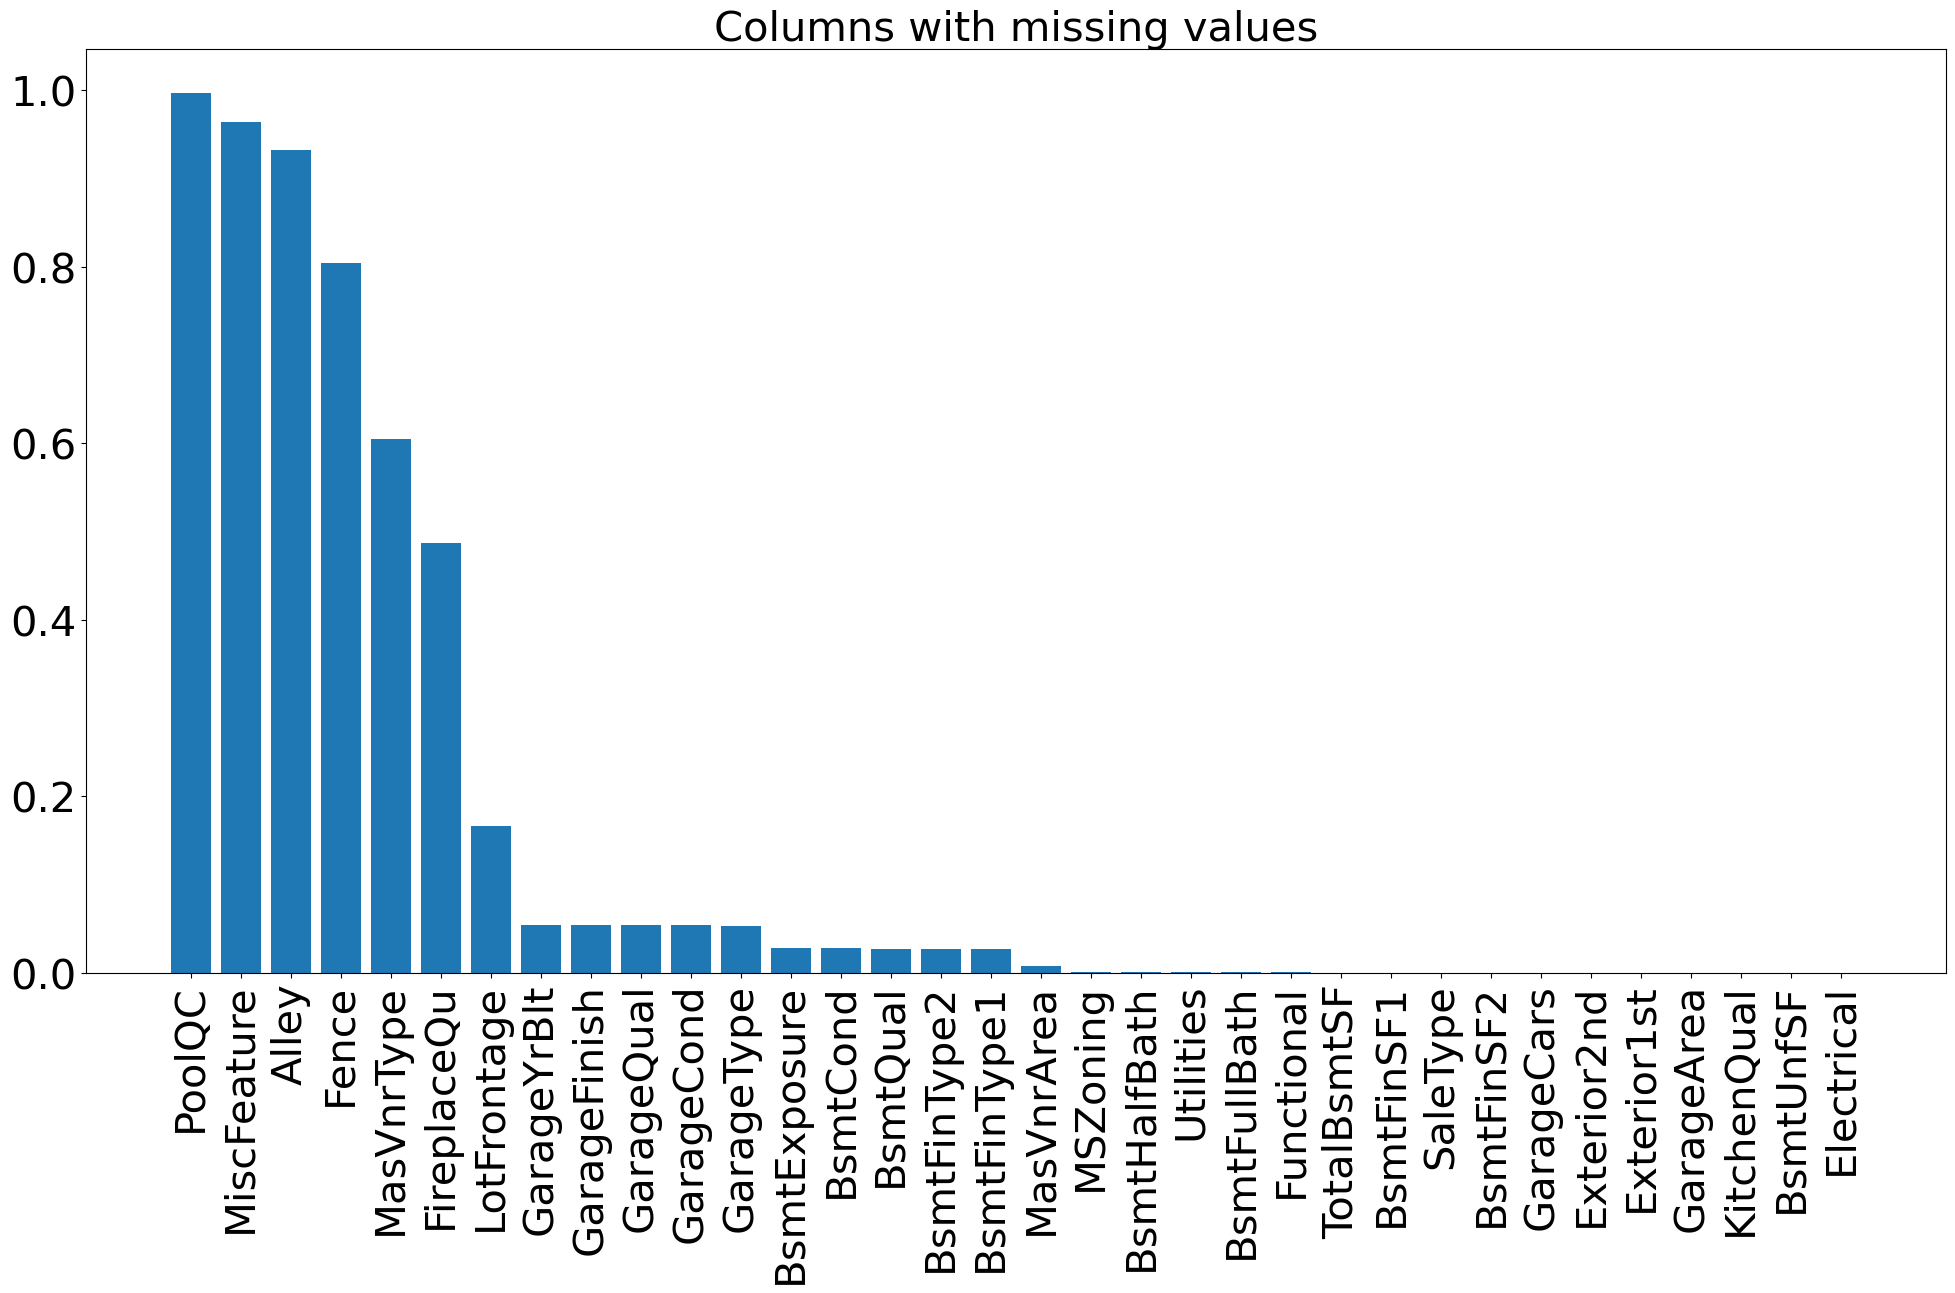

In [11]:
# get columns with missing and sort
missings = house.isna().sum()/2919
missings = missings.sort_values(ascending=False)
# remove 0s
missings = missings[missings != 0]

# plot
plt.figure(figsize=(24,12))
plt.title("Columns with missing values", fontsize=30)
plt.xticks(rotation=90, fontsize=30)
plt.yticks(fontsize=30)
plt.bar(missings.index, missings)

## Missing Data

In [14]:
# It is important to note that a lot of "missing" values actually represent something
# in this dataset... After going through the documentation, the following variables
# have meaningful NA

special_cols = ["Alley", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", \
                "FireplaceQu", "GarageType", "GarageFinish", "GarageQual", "GarageCond", \
                "PoolQC", "Fence", "MiscFeature", "MasVnrType"]

# Fill them with special "None" category

for special_col in special_cols:
    house[special_col] = house[special_col].fillna("None")

house["MasVnrArea"] = house["MasVnrArea"].fillna(0)

# 2207 is not valid year. Looking at this row, 2007 makes sense

house.loc[2592, "GarageYrBlt"] = 2007

# MSSubClass is actually categorical, not an int

house["MSSubClass"] = house["MSSubClass"].astype("category")
house["MoSold"] = house["MoSold"].astype("category")

# impute missing garageyrblt with mean

# house = house.drop(["GarageYrBlt"],axis=1)

house["GarageYrBlt"] = house["GarageYrBlt"].fillna(np.mean(house["GarageYrBlt"]))

# Again. no garage

house["GarageCars"] = house["GarageCars"].fillna(0)
house["GarageArea"] = house["GarageArea"].fillna(0)

# No basement

house["BsmtFinSF1"] = house["BsmtFinSF1"].fillna(0)
house["BsmtFinSF2"] = house["BsmtFinSF2"].fillna(0)
house["BsmtUnfSF"] = house["BsmtUnfSF"].fillna(0)
house["TotalBsmtSF"] = house["TotalBsmtSF"].fillna(0)
house["BsmtFullBath"] = house["BsmtFullBath"].fillna(0)
house["BsmtHalfBath"] = house["BsmtHalfBath"].fillna(0)

# Removing MiscVal

house = house.drop(["MiscVal"],axis=1)

<BarContainer object of 9 artists>

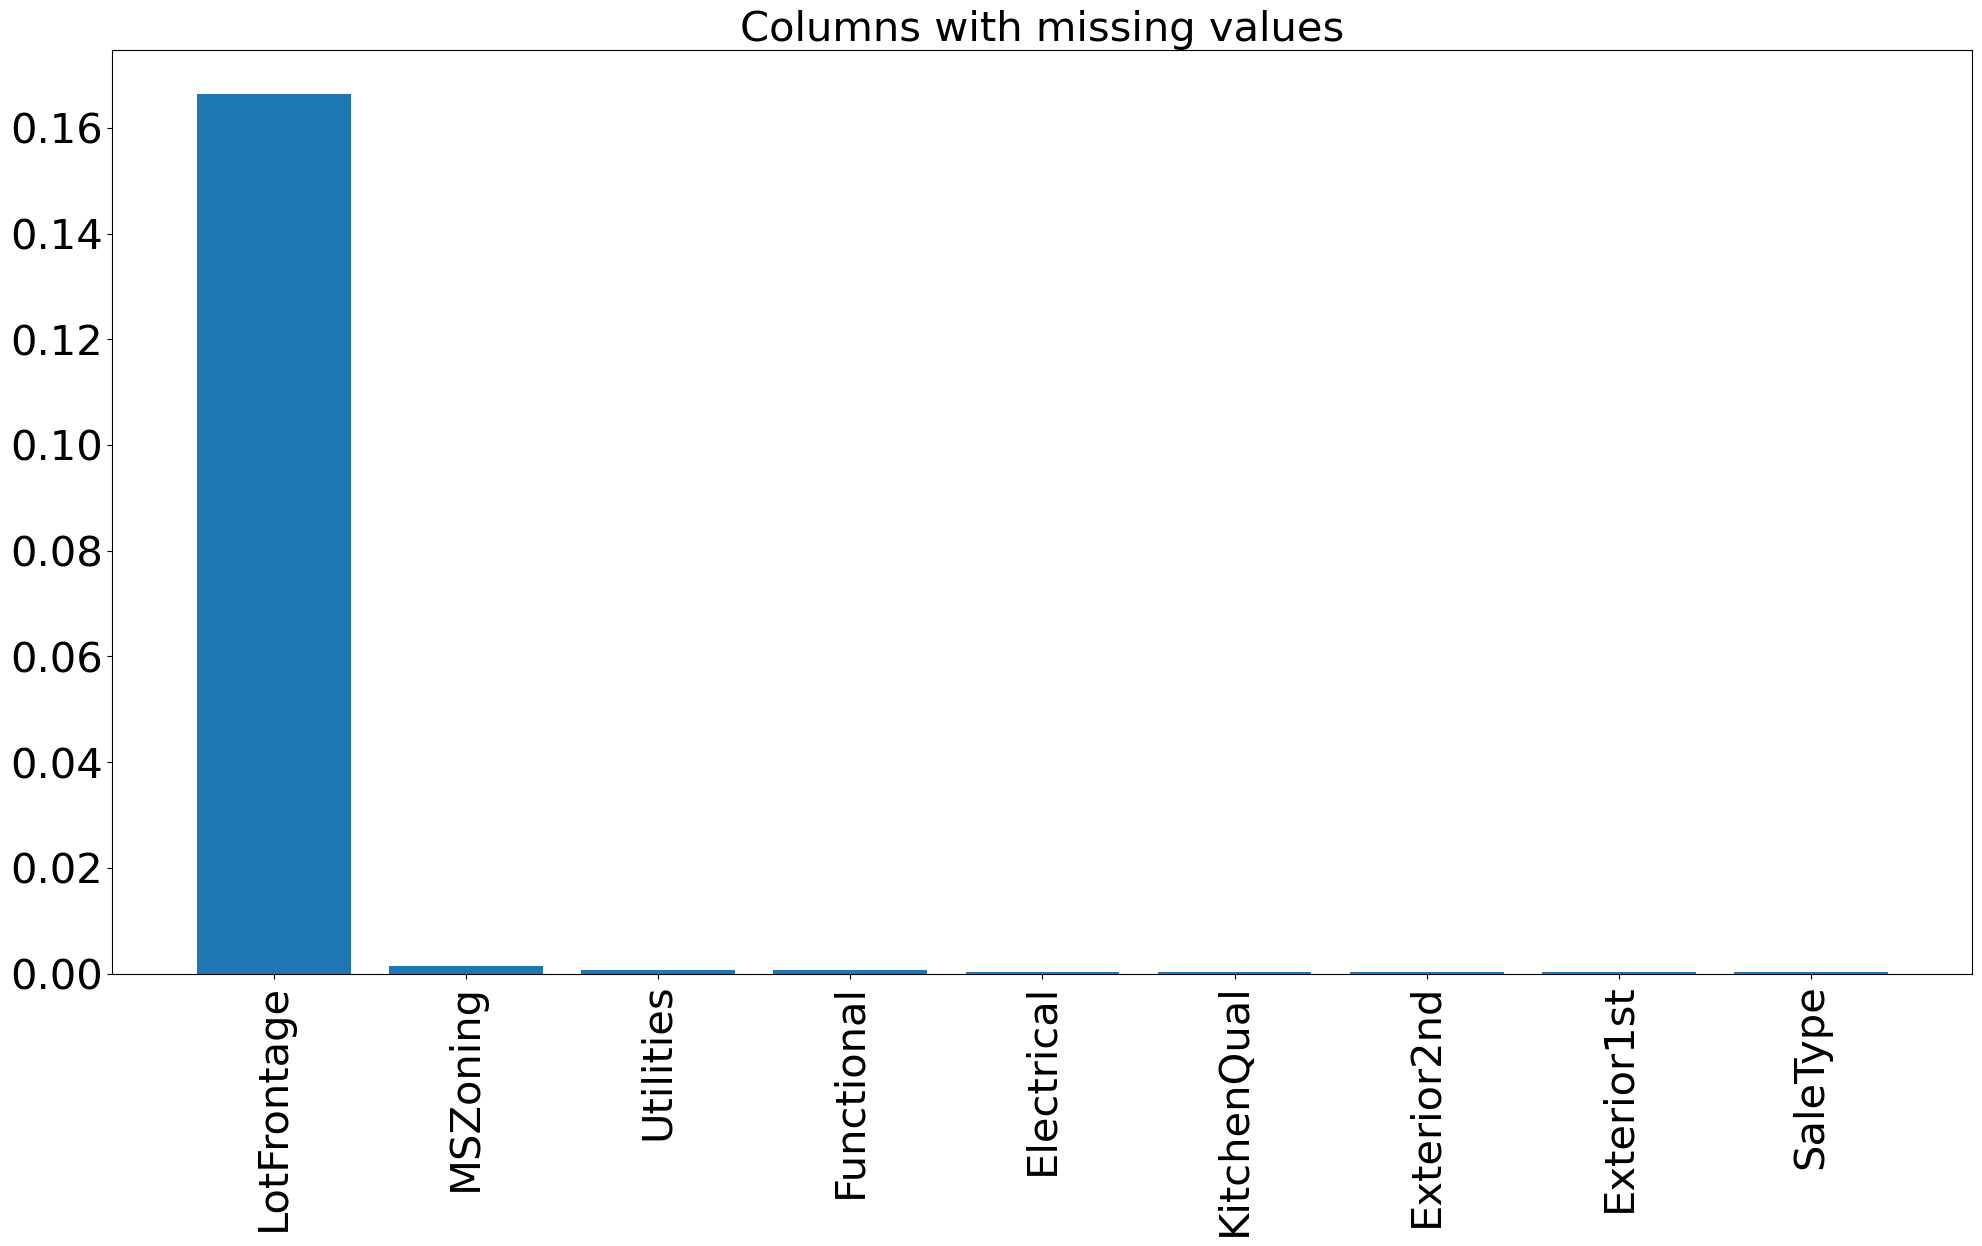

In [16]:
# now that meaningful mising values are filled, let's plot again

# get columns with missing and sort
missings = house.isna().sum()/2919
missings = missings.sort_values(ascending=False)
# remove 0s
missings = missings[missings != 0]

# plot
plt.figure(figsize=(24,12))
plt.title("Columns with missing values", fontsize=30)
plt.xticks(rotation=90, fontsize=30)
plt.yticks(fontsize=30)
plt.bar(missings.index, missings)

In [18]:
# Get the names of the rest of the missing columns
missing_cols = house.columns[house.isna().sum()>0]

In [20]:
# Categorical Columns:
for col in missing_cols:
   if not pd.api.types.is_numeric_dtype(house[col]):
        house.loc[house[col].isna(), col] = house[col].mode()[0]

In [22]:
# All that is left is to predict LotFrontage

# standardizing for knn
scaler = preprocessing.StandardScaler()

# dummy encode
house_dummies = pd.get_dummies(house)

# rows with nothing missing
house_no_na = house_dummies[np.invert(house.isna().any(axis=1))]
# rows with missing lot frontage
house_na = house_dummies[house.isna().any(axis=1)]

# train X
notfrontage_train = scaler.fit_transform(np.asarray(house_no_na.drop(["LotFrontage"],axis=1)))
# train y
frontage_train = np.asarray(house_no_na["LotFrontage"])
# test x
notfrontage_test = scaler.fit_transform(np.asarray(house_na.drop(["LotFrontage"],axis=1)))

# # knn k=1 and predict on the closest home
knn_model = KNeighborsRegressor(n_neighbors=1).fit(notfrontage_train, frontage_train)
frontage_pred = knn_model.predict(notfrontage_test)

# # replace na with predictions
house.loc[house["LotFrontage"].isna(), "LotFrontage"] = frontage_pred

In [24]:
# calculate the number of missing values left in the data

np.sum(house.isna().sum())

0

## Ordinal Encoding
The following section is simply encoding variables that appear ordinal as a numerical rating. My final draft for the project may alter these encodings if necessary.

In [27]:
# Categorical Variables:

#### Ordinal (need to know for ordinal encoding) ###################

# LotShape - 0,1,2,3 : IR3,IR2,IR1,Reg
mp = {"IR3":0,"IR2":1,"IR1":2,"Reg":3}
house["LotShape"] = house["LotShape"].map(mp)

# LandSlope - 0,1,2 : Gtl,Mod,Sev
mp = {"Gtl":0,"Mod":1,"Sev":2}
house["LandSlope"] = house["LandSlope"].map(mp)

# ExterQual - 0,1,2,3,4 : Po,Fa,TA,Gd,Ex
mp = {"Po":0,"Fa":1,"TA":2,"Gd":3,"Ex":4}
house["ExterQual"] = house["ExterQual"].map(mp)

# ExterCond - 0,1,2,3,4 : Po,Fa,TA,Gd,Ex
mp = {"Po":0,"Fa":1,"TA":2,"Gd":3,"Ex":4}
house["ExterCond"] = house["ExterCond"].map(mp)

# BsmtQual - 0,1,2,3,4,5 : None,Po,Fa,TA,Gd,Ex
mp = {"None":0,"Po":1,"Fa":2,"TA":3,"Gd":4,"Ex":5}
house["BsmtQual"] = house["BsmtQual"].map(mp)

# BsmtCond - 0,1,2,3,4,5 : None,Po,Fa,TA,Gd,Ex
mp = {"None":0,"Po":1,"Fa":2,"TA":3,"Gd":4,"Ex":5}
house["BsmtCond"] = house["BsmtCond"].map(mp)

# BsmtFinType1 - 0,1,2,3,4,5,6 : None,Unf,LwQ,Rec,BLQ,ALQ,GLQ
mp = {"None":0,"Unf":1,"LwQ":2,"Rec":3,"BLQ":4,"ALQ":5,"GLQ":6}
house["BsmtFinType1"] = house["BsmtFinType1"].map(mp)

# BsmtExposure - 0,1,2,3,4,5 : None,Po,No,Mn,Av,Gd
mp = {"None":0,"Po":1,"No":2,"Mn":3,"Av":4,"Gd":5}
house["BsmtExposure"] = house["BsmtExposure"].map(mp)

# HeatingQC - 0,1,2,3,4 : Po,Fa,TA,Gd,Ex
mp = {"Po":0,"Fa":1,"TA":2,"Gd":3,"Ex":4}
house["HeatingQC"] = house["HeatingQC"].map(mp)

# KitchenQual - 0,1,2,3,4 : Po,Fa,TA,Gd,Ex
mp = {"Po":0,"Fa":1,"TA":2,"Gd":3,"Ex":4}
house["KitchenQual"] = house["KitchenQual"].map(mp)

# FireplaceQu - 0,1,2,3,4,5 : NA,Po,Fa,TA,Gd,Ex
mp = {"None":0,"Po":1,"Fa":2,"TA":3,"Gd":4,"Ex":5}
house["FireplaceQu"] = house["FireplaceQu"].map(mp)

# GarageFinish - 0,1,2,3 : NA,Unf,RFn,Fin
mp = {"None":0,"Unf":1,"RFn":2,"Fin":3}
house["GarageFinish"] = house["GarageFinish"].map(mp)

# GarageQual - 0,1,2,3,4,5 : NA,Po,Fa,TA,Gd,Ex
mp = {"None":0,"Po":1,"Fa":2,"TA":3,"Gd":4,"Ex":5}
house["GarageQual"] = house["GarageQual"].map(mp)

# GarageCond - 0,1,2,3,4,5 : NA,Po,Fa,TA,Gd,Ex
mp = {"None":0,"Po":1,"Fa":2,"TA":3,"Gd":4,"Ex":5}
house["GarageCond"] = house["GarageCond"].map(mp)

# PoolQC - 0,1,2,3,4 : NA,Fa,TA,Gd,Ex
mp = {"None":0,"Fa":1,"TA":2,"Gd":3,"Ex":4}
house["PoolQC"] = house["PoolQC"].map(mp)


In [29]:
# Save data at this point for plotting later
D = house.loc[np.arange(0,train.shape[0],1),]
D["SalePrice"] = train["SalePrice"]

## Treatment Encoding

Now that we have seen some of the relationships between the predictors and the SalePrice, its time to finish this analysis by preparing the data for a future model.

In [32]:
#### Nominal (need to know for treatment encoding) ######################

# MSZoning,Street,Alley,LandContour,Utilities,LotConfig,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,
# RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,Foundation,BsmtFinType1,BsmtFinType2,Heating,CentralAir,
# Electrical,Functional,GrarageType,PavedDrive,Fence,MiscFeature,SaleType,SaleCondition

house = pd.get_dummies(house, drop_first=True)

## Standardization

Although decision tree methods may not require it, standardizing the features may be useful for other types of models.

In [35]:
# #### Center and Scale all attributes ################################

# this will change the form of the treatment encoding, but the gist is the same.

house = pd.DataFrame(scaler.fit_transform(house), columns=house.columns)

In [37]:
# First n1 rows are still the training data
train_filled = house.loc[np.arange(0,train.shape[0],1),]
train_filled["SalePrice"] = train["SalePrice"]
# last n2 rows are still the testing data
test_filled = house.loc[train.shape[0]:,]
test_filled = test_filled.reset_index(drop=True)

## Exploratory Data Analysis

Using a base xgboost model, I will extract the features that are deemed most important according to the training, and take a look at them.

In [40]:
# X, y represent the training features and log-target
# I have truth as a flattened y for simplicity later
X = np.asarray(train_filled.drop(["SalePrice"],axis=1))
y = np.vstack(np.log(np.asarray(train_filled["SalePrice"])))
truth = y.flatten()

In [42]:
# Hyperparameters arbitrarily chosen
eda_model = XGBRegressor(n_estimators=500, max_depth=4, learning_rate=0.06)

# Fit the model
eda_model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.06, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<Axes: title={'center': 'Feature importance'}, xlabel='weight', ylabel='Features'>

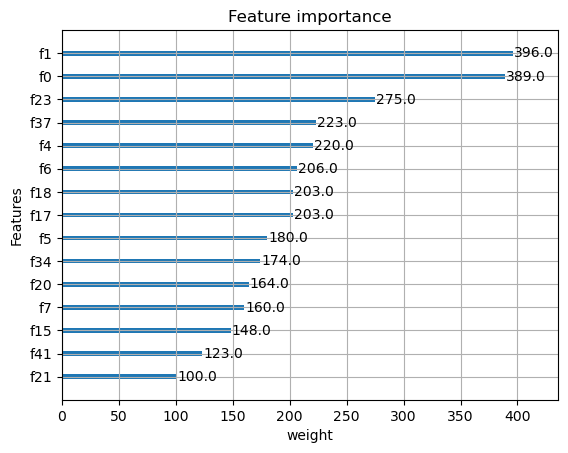

In [44]:
# Plot importance scores
plot_importance(eda_model, max_num_features=15, importance_type="weight", xlabel="weight")

In [46]:
# Get col indices from plot
col_idx = [1,0,23,37,4,6,18,17,5,34,20,7,15,41,21]

# Print list of col names in order of weight
list(train_filled.columns[col_idx])

['LotArea',
 'LotFrontage',
 'GrLivArea',
 'GarageArea',
 'OverallQual',
 'YearBuilt',
 'TotalBsmtSF',
 'BsmtUnfSF',
 'OverallCond',
 'GarageYrBlt',
 '1stFlrSF',
 'YearRemodAdd',
 'BsmtFinSF1',
 'OpenPorchSF',
 '2ndFlrSF']

I will choose to take a look at the top 5 most important features according to the number of times the feature occured in the xgboost model.

Text(0, 0, 'Corr: 0.2638433538714056')

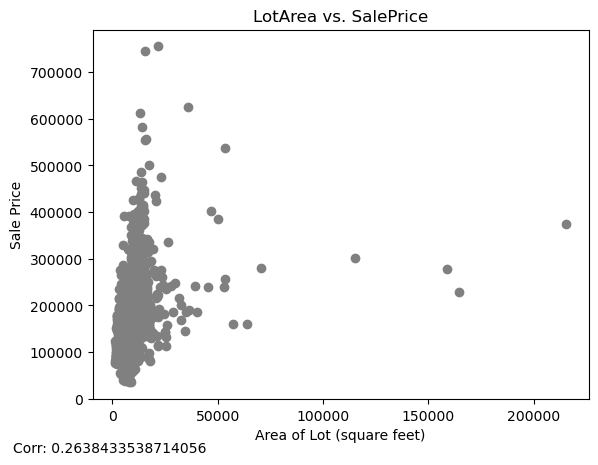

In [49]:
# LotArea - Lot size in square feet

plt.plot(D["LotArea"], D["SalePrice"], "o",
         color = "gray")
plt.xlabel("Area of Lot (square feet)")
plt.ylabel("Sale Price")
plt.title("LotArea vs. SalePrice")
plt.figtext(0,0,"Corr: " + str(np.corrcoef(D["LotArea"],D["SalePrice"])[0,1]))

There appears to be a positive relationship between lot are and sales price. There are plenty of outlierish points, however. These outliers also do not have the highest prices either. They weaken the correlation coefficient.

Text(0, 0, 'Corr: 0.34787926096048166')

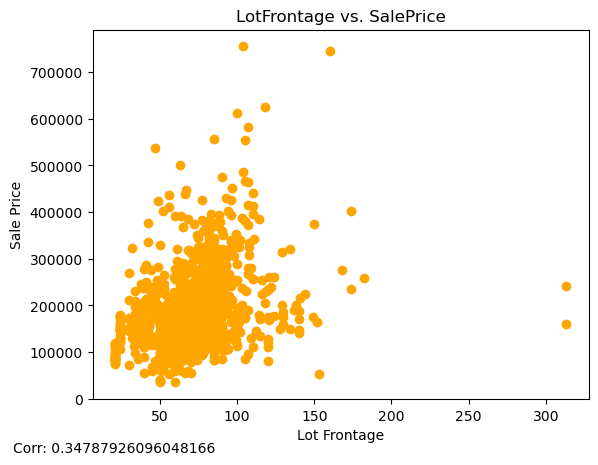

In [52]:
# LotFrontage - Lot Frontge

plt.plot(D["LotFrontage"], D["SalePrice"], "o",
         color = "orange")
plt.xlabel("Lot Frontage")
plt.ylabel("Sale Price")
plt.title("LotFrontage vs. SalePrice")
plt.figtext(0,0,"Corr: " + str(np.corrcoef(D["LotFrontage"],D["SalePrice"])[0,1]))

There appears to be a weak positive relationship between lot frontage and house price. It is important to note that a lot of these values for frontage were imputed as lot frontage contained many mising values.

Text(0, 0, 'Corr: 0.7086244776126521')

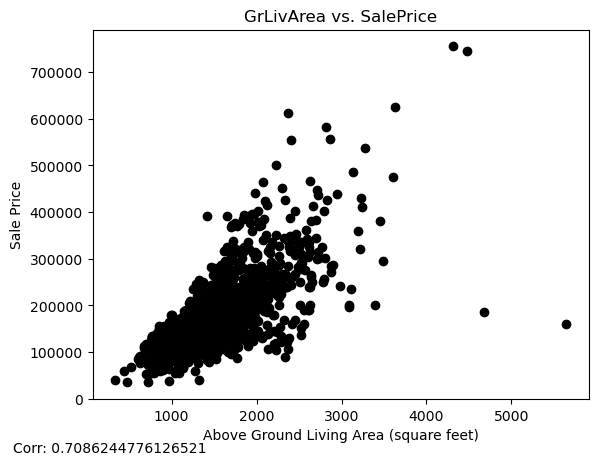

In [55]:
## GrLivArea - Above grade (ground) living area square feet

plt.plot(D["GrLivArea"], D["SalePrice"], "o",
         color = "black")
plt.xlabel("Above Ground Living Area (square feet)")
plt.ylabel("Sale Price")
plt.title("GrLivArea vs. SalePrice")
plt.figtext(0,0,"Corr: " + str(np.corrcoef(D["GrLivArea"],D["SalePrice"])[0,1]))

There is a clear and strong positive relationship between living area and sale price. This should be seen as no suprise. Interestingly, the variance does not seem as though it would be constant around an OLS regression line. The variance seems to increase as living area increases. Also, there appear to be a couple of houses with a lot of living area, but relatively low price.

Text(0, 0, 'Corr: 0.6234314389183616')

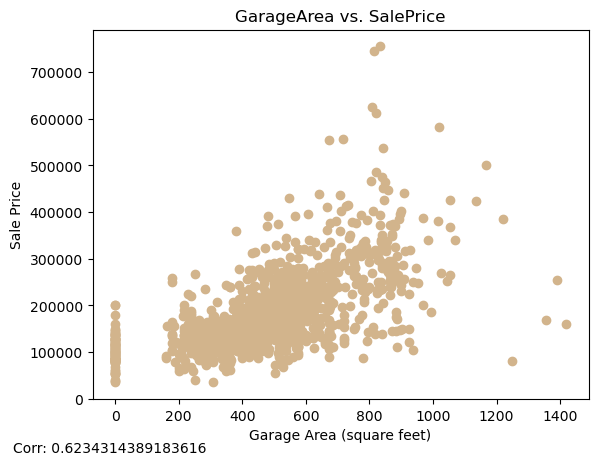

In [58]:
# GarageArea - Total square feet of garage area

plt.plot(D["GarageArea"],
         D["SalePrice"],
         "o",
         color = "tan")
plt.xlabel("Garage Area (square feet)")
plt.ylabel("Sale Price")
plt.title("GarageArea vs. SalePrice")
plt.figtext(0,0,"Corr: " + str(np.corrcoef(D["GarageArea"],D["SalePrice"])[0,1]))

There appears to be a strong positive relationship between garage area and sales price. Many points land at a garage area of 0, because these locations do not have a garage. It is important to note that none of the garage-less homes are among the top percentage of houses in terms of value, thus supporting the relationship.

Text(0, 0, 'Corr: 0.7909816005838052')

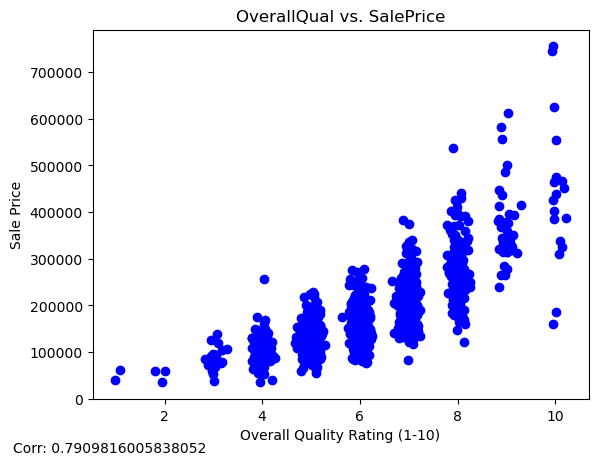

In [61]:
# OverallQual - Rates the overall material and finish of the house

plt.plot(D["OverallQual"]+np.random.normal(size=D.shape[0],loc=0,scale=0.1), # Horizontal jitter added for visual appeal
         D["SalePrice"],
         "o",
         color = "blue")
plt.xlabel("Overall Quality Rating (1-10)")
plt.ylabel("Sale Price")
plt.title("OverallQual vs. SalePrice")
plt.figtext(0,0,"Corr: " + str(np.corrcoef(D["OverallQual"],D["SalePrice"])[0,1]))

There is once again a strong positive relationship between these two variables that is not very suprising. However, this time we see a possible quadratic effect on sale price from increasing overall quality. Performing a regression on these two variables without accounting for this quadratic effect might be disingenuous.

## Building The Model

eXtreme Gradient Boosting (xgboost) is a very popular gradient boosted trees algorithm that was partly developed by Distributed Machine Learning Community (DMLC). Due to its impressive performance on a variety of machine learning competetions, xgboost has sparked many other companies to develop their own versions of gradient boosted tree algorithms. The most popular alternatives to xgboost, called Light Gradient Boosting Machine (LGBM) and Catboost, developed by Microsoft and Yandex respectively, have been introduced in order to provide small changes and improvements to the original xgboost algorithm. As part of the project, I would like to use all three of these algorithms in the same model to potentially provide increased performance, and identify which method is prefered according to training peformance.

In [65]:
def RMSE(pred, truth):
    # pred, truth must be 1d arrays
    return np.sqrt(np.mean((pred-truth)**2))

# Function to perform cross validation and estimate testing error
def cv_scores(mod, X, y, cv=10):
    return -cross_val_score(mod, 
                                X, 
                                y, 
                                scoring="neg_root_mean_squared_error", 
                                cv=cv)

In [67]:
# Model 1 - eXtreme Gradient Boosting

# Create hyperparameter grid for xgboost
xgb_grid = {"n_estimators": np.arange(900,1500,50),
            "max_depth": np.arange(2,5,1),
            "learning_rate": np.arange(0.02,0.11,0.04),
            "colsample_bytree": np.arange(0.02,0.12,0.02)}

# initialize model
xgb = XGBRegressor()

# fit the grid search
xgb_cv = GridSearchCV(xgb, xgb_grid, cv=8)
xgb_cv.fit(X,y)

# Print the best estimator
print(xgb_cv.best_estimator_)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.1, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1450, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)


In [80]:
# Verify the best estimators CV performance on 10 folds

xgb = XGBRegressor(n_estimators=950, max_depth=3, learning_rate=0.06, colsample_bytree = 0.1)
np.mean(cv_scores(xgb, X, y))

0.1195796194093978

In [82]:
# Model 2 - Light Gradient Boosting Machine

# Create hyperparameter grid
lgb_grid = {"n_estimators": np.arange(800,1150,50),
            "max_depth": np.arange(2,5,1),
            "learning_rate": np.arange(0.02,0.12,0.04),
            "colsample_bytree": np.arange(0.1,0.6,0.1)}

# Initialize model
lgb_mod = LGBMRegressor(verbose=-1)

# Fit grid search
lgb_cv = GridSearchCV(lgb_mod, lgb_grid, cv=8)
lgb_cv.fit(X,y.flatten())

# Print best estimator
print(lgb_cv.best_estimator_)

/opt/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


LGBMRegressor(colsample_bytree=0.30000000000000004, learning_rate=0.02,
              max_depth=4, n_estimators=1100, verbose=-1)


In [90]:
# Verify best estimator CV performance on 10 folds

lgb = LGBMRegressor(n_estimators=1100, max_depth=4, learning_rate=0.02, colsample_bytree = 0.3, verbose=-1)
np.mean(cv_scores(lgb, X, y.flatten()))

0.11961039236158802

In [93]:
# Model 3 - CatBoost

# Create hyperparameter grid
cb_grid = {"iterations": np.arange(800,1200,100),
            "depth": np.arange(3,5,1),
            "learning_rate": np.arange(0.02,0.12,0.04),
            "colsample_bylevel": np.arange(0.02,0.12,0.02)}

# Initialize model
cb_mod = CatBoostRegressor(verbose=0)

# Fit grid search
cb_cv = GridSearchCV(cb_mod, cb_grid, cv=8)
cb_cv.fit(X,y.flatten())

# Print best estimator
cb_cv.best_params_

{'colsample_bylevel': 0.08,
 'depth': 4,
 'iterations': 1100,
 'learning_rate': 0.06}

In [96]:
# Verify best estimator CV performance on 10 folds

cb = CatBoostRegressor(iterations=1100, depth=4, learning_rate=0.06, colsample_bylevel = 0.1, verbose=0)
np.mean(cv_scores(cb, X, y.flatten()))

0.11978853936886022

In [98]:
# Final Model - Linear Combination of Model 1-3 Predictions

# Get the list of each model having their best respective hyperparameters
estimators = [
    ("lgb", LGBMRegressor(n_estimators=1100, max_depth=4, learning_rate=0.02, colsample_bytree = 0.3, verbose=-1)),
    ("cb", CatBoostRegressor(iterations=1100, depth=4, learning_rate=0.06, colsample_bylevel = 0.1, verbose=0)),
    ("xgb", XGBRegressor(n_estimators=950, max_depth=3, learning_rate=0.06, colsample_bytree = 0.1))
]

# Initialize StackingRegressor with a final estimator of LinearRegression
# This has the effect of performing something similar to a weighted average on the prediction of each of the three models
mod = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression()
)

# Obtain 10-fold CV test performance for our model 
np.mean(cv_scores(mod, X, y.flatten()))


0.11737154561689193

In [101]:
# Fit the final model on all of the training data
final_mod = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())
final_mod.fit(X,y.flatten())

# Use this model to make predictions on the testing data
pred = np.exp(final_mod.predict(np.asarray(test_filled)))

In [103]:
# Collect the results and submit to Kaggle
submission = pd.DataFrame({"Id":test["Id"], "SalePrice": pred})
submission.to_csv("submission_extra5.csv", index=False)
# 0.12008

## Extra Model Analysis

The following is a breif analysis of the structure of the final model.

In [106]:
# Print the linear regression coefficients

pd.DataFrame({"Prediction Coefficient":final_mod.final_estimator_.coef_,
              "Algorithm": ["LGBM", "CatBoost", "xgboost"]})

,Prediction Coefficient,Algorithm
0,0.343784,LGBM
1,0.348395,CatBoost
2,0.322057,xgboost


In [108]:
# Correlation of algorithm outputs

# Fit models
xgb.fit(X,y.flatten())
lgb.fit(X,y.flatten())
cb.fit(X,y.flatten())

# Display results
res = pd.DataFrame({"XGB":xgb.predict(X),
                    "LGBM":lgb.predict(X),
                    "CB":cb.predict(X)})

res.corr()

,XGB,LGBM,CB
XGB,1.00000,0.996330,0.998450
LGBM,0.99633,1.000000,0.996626
CB,0.99845,0.996626,1.000000


The stacking regressor linear model seems to have slightly prefered the predictions of xgboost relative to LGBM and Catboost during training. However, this can be misleading considering the high correlation between outputs. Below is a look at feature importances using SHAP across all 3 models.

Text(0.5, 1.0, 'xgboost Feature Importance')

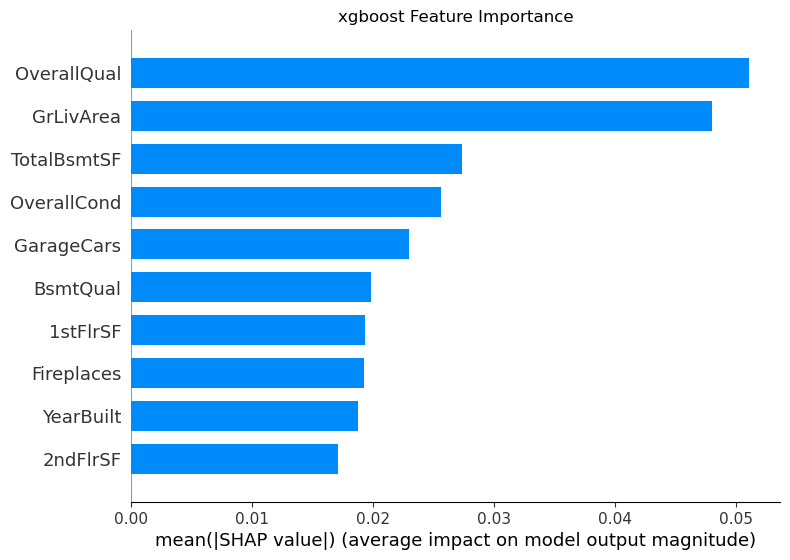

In [111]:
## xgboost mean absolute shap values
shap.summary_plot(shap.TreeExplainer(final_mod.estimators_[2]).shap_values(X,y), 
                  feature_names=test_filled.columns, 
                  plot_type="bar",
                  max_display=10,
                  show=False)
plt.title("xgboost Feature Importance")

Text(0.5, 1.0, 'LGBM Feature Importance')

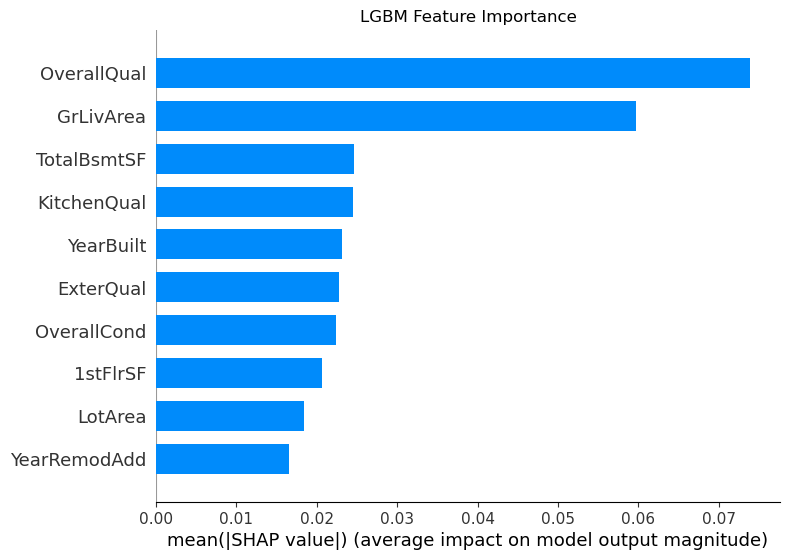

In [113]:
## lgbm mean absolute shap values
shap.summary_plot(shap.TreeExplainer(final_mod.estimators_[0]).shap_values(X,y), 
                  feature_names=test_filled.columns, 
                  plot_type="bar",
                  max_display=10,
                  show=False)
plt.title("LGBM Feature Importance")

Text(0.5, 1.0, 'CatBoost Feature Importance')

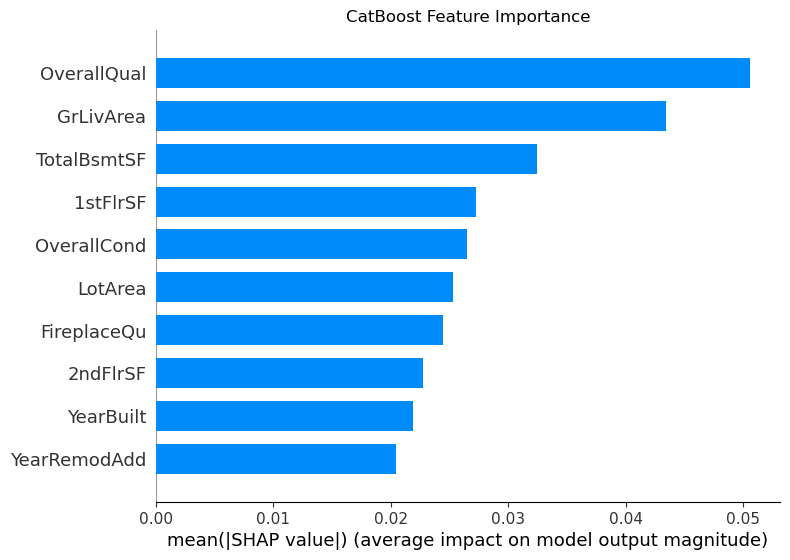

In [115]:
# CatBoost mean absolute shap values
shap.summary_plot(shap.TreeExplainer(final_mod.estimators_[1]).shap_values(X,y), 
                  feature_names=test_filled.columns, 
                  plot_type="bar",
                  max_display=10,
                  show=False)
plt.title("CatBoost Feature Importance")

According to the mean absolute shap values for all 3 models, OverallQual and GrLivArea dominate in terms of importance. 